# IT News Project

The project aims to analyze IT news articles and recommend related articles to identify patterns, trends. This could help in understanding certain topics or discovering emerging themes in current events.

# Part 1: Scraping and Crawling

We will use multiple websites to scrape the articles. Each website has a different snippet of code as the method to get the articles is adapted to each website.

####Code to execute before the others, all the other scraping snippets can be executed individually though

In [16]:
#for the first time launching google collab (packages to install)
!pip install beautifulsoup4 python-dateutil datasketch scikit-learn pandas

In [ ]:
#to execute each time (imports used everywhere)
!pip install python-dotenv
import requests
from bs4 import BeautifulSoup
import csv
import json
import time
import dateutil
import pandas as pd


### New York Times Articles
New York Times has its own API so we will use it. More specifically we will use the article search API.

####Execute this code before to create the .env file for the NYT API Key

**If you want to retrieve New York Times articles**


In [ ]:
with open('.env', 'w') as f:
    f.write("API_KEY=W4DCpxZiGY6T8r2AP97p5gMQht3lF6gt\n")

Main Code for New York Times (This takes around 10 mins)

In [ ]:
import os
import urllib3
from dotenv import load_dotenv
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#load api key
load_dotenv()

####################
####PARAMETERS######
####################
API_KEY = os.getenv('API_KEY')  # my API key retrieved from NYT API service
NYT_base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'# base URL for the NYT API

# function to send a request to the NYT API
def send_request(page):
    params = {
        'q': 'technology',
        'api-key': API_KEY,
        'page': page
    }

    try:
        # make a GET request to the NYT API
        response = requests.get(NYT_base_url, params=params, verify=False)
        response.raise_for_status()  # raise an error for HTTP issues
        time.sleep(12)  # delay to prevent rate-limiting (They allow 10 requests per minute so to make sure to respect that)
        return response.json()
    except Exception as e:
        print(f"Error fetching data for page {page}: {e}")
        return None

# function to check if the article is well structured
def is_valid(article):
    # check if the article has a headline and main text
    return 'headline' in article and 'main' in article['headline']

# function to parse the response data into a DataFrame
def parse_response(response):
    # initialize data structure fields
    data = {
        'URL': [],
        'Title': [],
        'Author': [],
        'Publication Date': [],
        'Content': [], # content will be empty since the NYT doesn't give access to the full text
        'Keywords': []
    }

    # extract information from each article
    articles = response['response']['docs']
    for article in articles:
        if is_valid(article):
            # append relevant data to the dictionary
            data['URL'].append(article['web_url'])
            data['Title'].append(article['headline']['main'])
            data['Author'].append(article.get('byline', {}).get('original', "No Author Found"))
            data['Publication Date'].append(dateutil.parser.parse(article['pub_date']).date())
            data['Content'].append("")  #empty since there is no text
            keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
            data['Keywords'].append(", ".join(keywords) if keywords else "No Keywords Found")# store keywords as a comma-separated string


    return pd.DataFrame(data)

# function to collect articles from multiple pages and save them as a single CSV
def get_NYT_multiple_pages(start_page,nb_pages):
    all_articles = pd.DataFrame()

    #loop through multiple pages to fetch articles
    for page_num in range(start_page, nb_pages):
        print(f"Fetching page {page_num + 1}...")
        response = send_request(page_num)
        if response is not None:
            page_data = parse_response(response)
            all_articles = pd.concat([all_articles, page_data], ignore_index=True)
        else:
            print(f"Skipping page {page_num + 1} due to errors.")

    #check and remove if any duplicate URLs
    if 'URL' in all_articles.columns:
        initial_count = len(all_articles)
        all_articles = all_articles.drop_duplicates(subset='URL').reset_index(drop=True)
        final_count = len(all_articles)
        print(f"Removed {initial_count - final_count} duplicate articles based on URL.")
    else:
        print("No 'URL' column found. Skipping duplicate check.")

    #save the final DataFrame as a single CSV file
    csv_path = "/content/nyt_tech_articles2.csv" #change the name for the different versions of the file
    all_articles.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"Data saved to {csv_path}")


# specify the number of pages to scrape
#get_NYT_multiple_pages(0,50) this was for the first 500 requests
get_NYT_multiple_pages(50,100) # this is for the second 500 requests


Fetching page 51...
Fetching page 52...
Fetching page 53...
Fetching page 54...
Fetching page 55...
Fetching page 56...
Fetching page 57...
Fetching page 58...
Fetching page 59...
Fetching page 60...
Fetching page 61...
Fetching page 62...
Fetching page 63...
Fetching page 64...
Fetching page 65...
Fetching page 66...
Fetching page 67...
Fetching page 68...
Fetching page 69...
Fetching page 70...
Fetching page 71...
Fetching page 72...
Fetching page 73...
Fetching page 74...
Fetching page 75...
Fetching page 76...
Fetching page 77...
Fetching page 78...
Fetching page 79...
Fetching page 80...
Fetching page 81...
Fetching page 82...
Fetching page 83...
Fetching page 84...
Fetching page 85...
Fetching page 86...
Fetching page 87...
Fetching page 88...
Fetching page 89...
Fetching page 90...
Fetching page 91...
Fetching page 92...
Fetching page 93...
Fetching page 94...
Fetching page 95...
Fetching page 96...
Fetching page 97...
Fetching page 98...
Fetching page 99...
Fetching page 100...

Combine two days worth of scraping (NYT API only allows 500 requests per day)

In [ ]:
#list of specific CSV files to combine (so we exclude NYT articles)
csv_files = [
    "/content/nyt_tech_articles.csv",
    "/content/nyt_tech_articles2.csv"
]

output_file = "combined_nyt_csvs.csv"

#list to hold DataFrames
dataframes = []

#loop through the list of the CSVs
for file in csv_files:
    print(f"Reading {file}")
    #read each CSV file and append it to the list
    df = pd.read_csv(file)
    dataframes.append(df)

#combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

#save the combined DataFrame to a new CSV file
combined_df.to_csv(output_file, index=False)
print(f"Combined CSV saved to {output_file}")


Reading /content/nyt_tech_articles.csv
Reading /content/nyt_tech_articles2.csv
Combined CSV saved to combined_nyt_csvs.csv


### Tech Crunch
Tech Crunch is a news website dedicated to technological news. Therefore, we will crawl the latest news pages and scrape each article on the page. This snippet takes around 10 mins (for me).

*Tech crunch also gives access to the sitemap so the crawling could have been done that way too.*

In [ ]:
####################
####PARAMETERS######
####################
TC_base_url = "https://techcrunch.com/latest/page/" #base URL latest news
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}#headers to pretend to be a browser

def fetch_page(url):
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.text

#function to parse article links from the page
def parse_article_links(page_html):
    soup = BeautifulSoup(page_html, 'html.parser')
    article_links = []

    #look for links with the correct class name
    for article in soup.find_all('a', class_='loop-card__title-link'):
        article_url = article.get('href')

        #exclude links that contain '/podcast/'
        if '/podcast/' not in article_url:
            article_links.append(article_url)

    return article_links

#function to scrape the full text of an article and its components (title, author, date)
def scrape_TC_article(url):
    try:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        title = soup.find('title')
        title = title.text.strip() if title else "No Title Found"

        author_meta = soup.find('meta', attrs={'name': 'author'})
        author = author_meta['content'].strip() if author_meta else "No Author Found"

        date = soup.find('meta', attrs={'property': 'article:published_time'})
        date = dateutil.parser.parse(date['content']).date() if date else "No Date Found"

        #try to find all <p> tags with the class 'wp-block-paragraph'
        paragraphs = soup.find('div', attrs={'class': 'entry-content wp-block-post-content is-layout-constrained wp-block-post-content-is-layout-constrained'}).find_all('p')
        content = "\n".join(p.text.strip() for p in paragraphs if p.text)

        return {'URL': url, 'Title': title, 'Author': author, 'Publication Date': date, 'Content': content}
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return {'URL': url, 'Title': None, 'Author': None, 'Publication Date': None, 'Content': None}

#function to scrape multiple pages
def scrape_TC_multiple_pages(start_page=1, end_page=5):
    csv_filename = "tc_tech_articles.csv"
    scraped_urls = set()  # Set to track scraped URLs and avoid duplicates

    with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['URL', 'Title', 'Author', 'Publication Date', 'Content'])
        writer.writeheader()

        for page_num in range(start_page, end_page + 1):
            page_url = TC_base_url+f'{page_num}/'

            #fetch the page
            print(f"Fetching page: {page_url}")
            page_html = fetch_page(page_url)

            #extract article links from the page
            article_urls = parse_article_links(page_html)

            #scrape content from each article
            for article_url in article_urls:
                if article_url not in scraped_urls:  #check if URL is already scraped
                    article_data = scrape_TC_article(article_url)
                    if article_data['Content']:  #only save if content is non-empty
                        writer.writerow(article_data)
                        scraped_urls.add(article_url)  #add URL to the set
                else:
                  time.sleep(1)  # wait for 1 second between requests to avoid overloading server

    print(f"Scraped articles are saved to {csv_filename}")

#run the scraper
scrape_TC_multiple_pages(start_page=1, end_page=51)


In [ ]:
import re

def clean_and_filter_articles(input_file, output_file):
    with open(input_file, mode='r', encoding='utf-8') as infile, open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames)
        writer.writeheader()

        #pattern to match date in URL
        date_pattern = re.compile(r'/\d{4}/\d{2}/\d{2}/')

        for row in reader:
            if row['URL'] and date_pattern.search(row['URL']):
                if row['Title']:
                    row['Title'] = row['Title'].replace('| TechCrunch', '').strip()
                    row['Title'] = row['Title'].replace('| Techcrunch', '').strip()
                writer.writerow(row)

    print(f"Titles cleaned and filtered articles saved to {output_file}")

input_file = "/content/tc_tech_articles.csv"
output_file = "/content/tc_tech_articles_cleaned.csv"
clean_and_filter_articles(input_file, output_file)

Titles cleaned and filtered articles saved to /content/tc_tech_articles_cleaned.csv


### Venture Beats
The sitemap for venturebeats archives the sites news everyday. So, we will crawl the sitemap will all the links to the archives, and then crawl each archive, and scrape all articles with the designed keyword (I choose all keywords for all the IT related categories on the main website). There are headers for each snippet of code, but this was added for Venture Beats in the first place, they are very strict with their Scraping/Crawling rules. This takes around 40 mins for 100 pages.

In [ ]:
####################
####PARAMETERS######
####################
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}#headers to pretend to be a browser
VB_sitemap_url = "https://venturebeat.com/sitemap.xml"

#fetch main sitemap where all archives of the sitemap of everyday are stored
def fetch_sitemap(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")
    sitemap_links = [loc.text for loc in soup.find_all("loc")]
    return sitemap_links

#filter tech related articles (so filter with keywords and take out additional content such as pictures, etc)
def is_article_url(url):
    exclude_keywords = ["wp-content", ".png", ".jpg", ".webp"]
    if any(keyword in url for keyword in exclude_keywords):
        return False
    include_keywords = ["/ai/", "/data-infrastructure/", "/programming-development/", "/automation/", "/security/"]
    return any(keyword in url for keyword in include_keywords)

#scrape each article
def scrape_VB_article(url):
    try:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        title = soup.find('h1', class_='article-title') or soup.find('title')
        title = title.text.strip() if title else "No Title Found"

        author_meta = soup.find('meta', attrs={'name': 'author'})
        author = author_meta['content'].strip() if author_meta else "No Author Found"

        date = soup.find('time')
        date = dateutil.parser.parse(date['datetime']).date() if date else "No Date Found"

        article_content = soup.find("div", class_="article-content")
        #remove unwanted elements with the specified class names
        for unwanted in article_content.find_all(["div", "form"], class_=["post-boilerplate", "boilerplate-before", "boilerplate-after"]):
            unwanted.decompose()

        if article_content:
            #extract only the text from the relevant section, ensuring it is cleaned up
            clean_text = article_content.get_text(separator="\n", strip=True)
        else:
            print("Article content not found!")
            clean_text = ""

        return {'URL': url, 'Title': title, 'Author': author, 'Publication Date': date, 'Content': clean_text}
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return {'URL': url, 'Title': None, 'Author': None, 'Publication Date': None, 'Content': None}

#fetch a certain number of days of archive on the main sitemap
def fetch_daily_sitemaps(main_sitemap, num_days=100):
    daily_sitemaps = []
    for i in range(min(num_days, len(main_sitemap))):
        daily_sitemaps.append(main_sitemap[i])
    return daily_sitemaps

def scrape_VB_multiple_pages(num_days=100):
    main_sitemap = fetch_sitemap(VB_sitemap_url)
    daily_sitemaps = fetch_daily_sitemaps(main_sitemap, num_days)
    #collect articles url
    all_urls = set()
    for daily_sitemap in daily_sitemaps:
        daily_urls = fetch_sitemap(daily_sitemap)
        all_urls.update(daily_urls)
        time.sleep(5)  #sleep to not overwhelm the server

    #filter URLs with the filtering method
    article_urls = [url for url in all_urls if is_article_url(url)]

    #scrape the articles one by one
    articles_data = []
    for url in article_urls:
        article_data = scrape_VB_article(url)
        if article_data['Content']:  # Save only when they have content
            articles_data.append(article_data)
        time.sleep(5)

    output_file = "/content/vb_tech_articles.csv"
    df = pd.DataFrame(articles_data)
    df.to_csv(output_file, index=False)
    print(f"Scraping complete. Data saved to {output_file}.")

#run the scraper
scrape_VB_multiple_pages(100)

#The Next Web

This scraper fetches and extracts article data from The Next Web's latest tech news section. It uses Requests to send HTTP requests and BeautifulSoup to parse HTML, targeting article links, then scraping content from each linked article. The results are saved in a CSV file, with small delays between requests to avoid overloading the server (no specifications in the robots.txt).

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time

####################
####PARAMETERS######
####################
crawl_TNW_base_url = "https://thenextweb.com/latest" #base url to crawl the website
TNW_base_url = "https://thenextweb.com" #base url to create articles url to scrape

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}

def fetch_page(url):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch {url}: {e}")
        return None

#function to parse article links from the page
def parse_article_links(page_html):
    if not page_html:
        return []
    soup = BeautifulSoup(page_html, 'html.parser')
    article_links = []

    article_container = soup.find('div', id='articleList')
    if not article_container:
        print("Article list not found on the page.")
        return article_links

    for article in article_container.find_all('a', class_='title_link', href=True):
        article_url = article['href']
        full_url = TNW_base_url + article_url if article_url.startswith('/') else article_url
        article_links.append(full_url)

    return article_links

#scrape the data of individual article
def scrape_TNW_article(url):
    try:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        title = soup.find('h1')
        title = title.text.strip() if title else "No Title Found"

        author_span = soup.find('span', class_='c-article__authorName latest')
        author = author_span.text.strip() if author_span else "No Author Found"

        date = soup.find('time')
        date = dateutil.parser.parse(date['datetime']).date() if date and 'datetime' in date.attrs else "No Date Found"

        paragraphs = soup.find('div', attrs={'id': 'article-main-content'})
        if paragraphs:
            paragraphs = paragraphs.find_all('p')
            content = "\n".join(p.text.strip() for p in paragraphs if p.text)
        else:
            content = "No Content Found"

        time.sleep(0.3)  #slight delay between requests since no specifics in robots.txt
        return {'URL': url, 'Title': title, 'Author': author, 'Publication Date': date, 'Content': content}
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return {'URL': url, 'Title': None, 'Author': None, 'Publication Date': None, 'Content': None}

#function to scrape multiple pages
def scrape_TNW_multiple_pages(start_page=1, end_page=5):
    csv_filename = "tnw_tech_articles.csv"
    scraped_urls = set()

    with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['URL', 'Title', 'Author', 'Publication Date', 'Content'])
        writer.writeheader()

        for page_num in range(start_page, end_page + 1):
            page_url = f"{crawl_TNW_base_url}/page/{page_num}/"
            print(f"Fetching page: {page_url}")
            page_html = fetch_page(page_url)

            article_urls = parse_article_links(page_html)
            for article_url in article_urls:
                if article_url not in scraped_urls:
                    article_data = scrape_TNW_article(article_url)
                    if article_data['Content']:
                        writer.writerow(article_data)
                        scraped_urls.add(article_url)

    print(f"Scraped articles are saved to {csv_filename}")

# Run the scraper
scrape_TNW_multiple_pages(start_page=1, end_page=300)

Each dataframe has been created according to the source code of each website, and has been checked for duplicates. The delay is also adapted to the robots.txt of the website if indicated.

#Combine the CSVs (except for NYT) together

For this code to work, you need to have all the CSVs in the content directory (I would recommend putting them directly and not executing the scraping code since it would take multiple hours)

In [ ]:
#list of specific CSV files to combine (so we exclude NYT articles)
csv_files = [
    "/content/tnw_tech_articles.csv",
    "/content/tc_tech_articles_cleaned.csv",
    "/content/vb_tech_articles.csv"
]

output_file = "combined_csvs.csv"

#list to hold DataFrames
dataframes = []

#loop through the list of the CSVs
for file in csv_files:
    print(f"Reading {file}")
    #read each CSV file and append it to the list
    df = pd.read_csv(file)
    dataframes.append(df)

#combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

#save the combined DataFrame to a new CSV file
combined_df.to_csv(output_file, index=False)
print(f"Combined CSV saved to {output_file}")


Reading /content/tnw_tech_articles.csv
Reading /content/tc_tech_articles_cleaned.csv
Reading /content/vb_tech_articles.csv
Combined CSV saved to combined_csvs.csv


# Part 2: Data Preprocessing

In [ ]:
def clean_content_column(input_file, output_file, word_to_remove):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    word_pattern = re.compile(re.escape(word_to_remove), re.IGNORECASE)

    with open(input_file, mode='r', encoding='utf-8') as infile, open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames)
        writer.writeheader()

        for row in reader:
            if 'Content' in row and row['Content']:
                #remove URLs
                row['Content'] = url_pattern.sub('', row['Content'])
                #remove the specified word (techcrunch initialy, but we can use later if need be)
                row['Content'] = word_pattern.sub('', row['Content'])
            writer.writerow(row)

    print(f"Links and the word '{word_to_remove}' removed from the 'Content' column. Cleaned data saved to {output_file}")
clean_content_column("combined_csvs.csv", "cleaned_combined_data.csv", "TechCrunch")


Links and the word 'TechCrunch' removed from the 'Content' column. Cleaned data saved to cleaned_combined_data.csv


# Part 3: Clustering

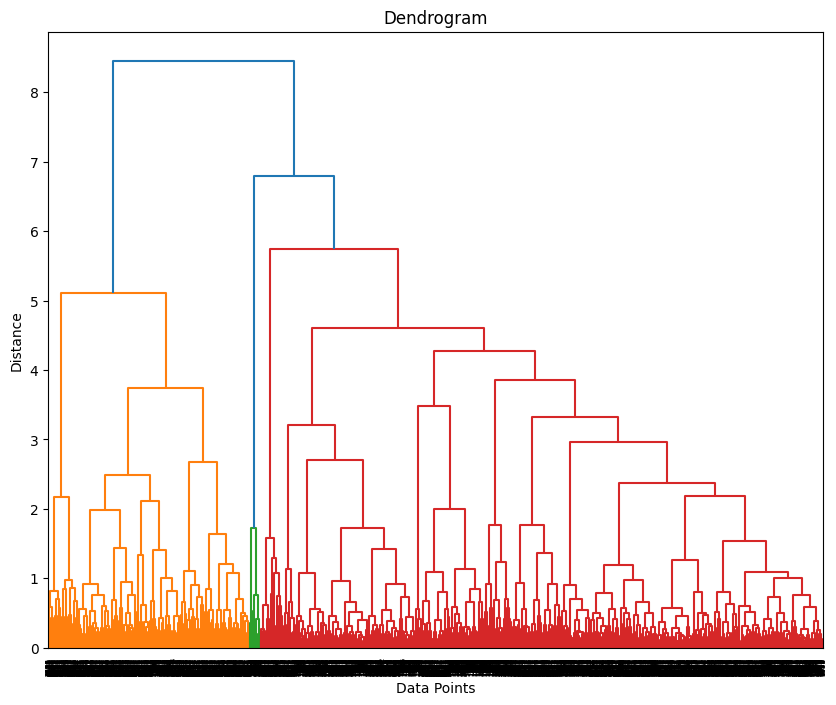

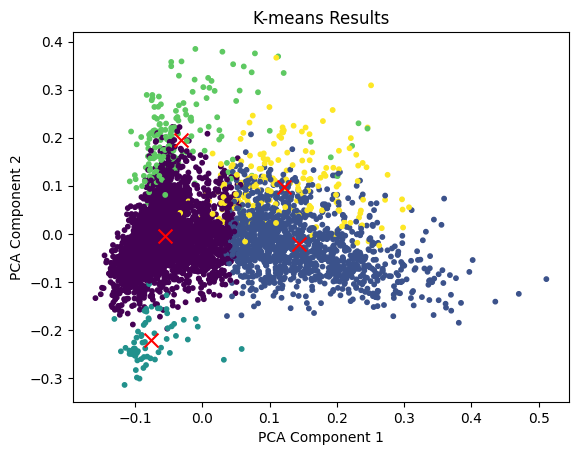

Cluster KeyWords: ['unicorn & companies & said & tech & company', 'agents & model & data & models & ai', 'classical & computers & qubits & computing & quantum', 'apps & ios & iphone & app & apple', '4o & gpt & ai & chatgpt & openai']

Cluster 'unicorn & companies & said & tech & company':
['https://thenextweb.com/news/swiss-startup-turning-rainy-days-into-refunds-launches-first-product', 'https://thenextweb.com/news/uk-hospitality-startup-lighthouse-enters-unicorn-club-with-370m-raise', 'https://thenextweb.com/news/candela-brings-electric-flying-ferry-us-funding-40-million-raise', 'https://thenextweb.com/news/dutch-startup-skytree-100-million-wind-powered-carbon-capture-plant-texas', 'https://thenextweb.com/news/tokamak-energy-secures-125m-to-commercialise-fusion-power', 'https://thenextweb.com/news/nanoprinter-turns-metas-ai-predictions-into-hundreds-of-nanomaterials', 'https://thenextweb.com/news/deepl-voice-ai-translation', 'https://thenextweb.com/news/dutch-startup-sympower-secures

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from datasketch import MinHash, MinHashLSH

# Load the dataset
news_data = pd.read_csv("cleaned_combined_data.csv")

'''
# check news_data dataframe
pd.set_option("display.max_columns", None)
print(news_data.head(10))
print(news_data.columns)
'''
# DataPreparation
## We don't need URL, Author, Publication Date Column.
## Create the textdata field which is combination of Title and Content field
news_data['textdata'] = news_data['Title'] + " " + news_data['Content']

## stop_words option functions as delete 'the' or 'is' etc
tfidf_data = TfidfVectorizer(stop_words='english')
# TF-IDF process
tfidf_matrix = tfidf_data.fit_transform(news_data['textdata'])

# Apply PCA
## To apply PCA, make it array
pca = PCA(n_components=10)
pca_data = pca.fit_transform(tfidf_matrix.toarray())

# Apply Hierarchical Clustering
## To make dendrogram, make link matrix
pca2linkage = linkage(pca_data, method='ward')

# Visualize dendrogram
plt.figure(figsize=(10, 8))
dendrogram(pca2linkage)
plt.title("Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

## Select the number of cluster & get the centroid value
hierarchical_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_data = hierarchical_clustering.fit_predict(pca_data)

## Count hierarchical_data's cluster and make it to list (if there are 5 clusters => [0,1,2,3,4])
unique_data = np.unique(hierarchical_data)

# Calculate each of the clusters centroid
centers_list = []
for label in unique_data:
    cluster_data = pca_data[hierarchical_data == label]
    cluster_center = cluster_data.mean(axis=0)
    centers_list.append(cluster_center)
initial_centroid = np.array(centers_list)

# Apply K-means
kmeans = KMeans(n_clusters=len(unique_data), init=initial_centroid)
kmeans_data = kmeans.fit_predict(pca_data)

# Visualize
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_data, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='x', s=100)
plt.title("K-means Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Print Cluster names
cluster_names = []

for i in range(len(np.unique(kmeans_data))):
    cluster_index = np.where(kmeans_data == i)[0]
    cluster_data = tfidf_matrix[cluster_index]
    # Calculate TF-IDF average (make it A1 numpy array)
    cluster_mean_tfidf = cluster_data.mean(axis=0).A1
    # Top-5 words
    top_keywords_array = np.argsort(cluster_mean_tfidf)[-5:]
    names = tfidf_data.get_feature_names_out()
    top_keywords = []
    for j in top_keywords_array:
        top_keywords.append(names[j])
    cluster_keywords = " & ".join(top_keywords)
    cluster_names.append(cluster_keywords)
print("Cluster KeyWords:", cluster_names)

# Output - Print Content(URLs) of the Clusters
cluster_names_column = []
for i in kmeans_data:
    cluster_names_column.append(cluster_names[i])
news_data['ClusterName'] = cluster_names_column
for i, j in enumerate(cluster_names):
    cluster_urls = news_data[news_data['ClusterName'] == j]['URL']
    print(f"\nCluster '{j}':")
    print(cluster_urls.tolist())

# Add cluster labels to the DataFrame
news_data['Cluster'] = hierarchical_data


# Part 3: LSH

In [24]:
# Define function to create MinHash
def get_minhash(doc):
    tokens = doc.split()
    m = MinHash(num_perm=128)
    for token in tokens:
        m.update(token.encode('utf8'))
    return m

# Create LSH for each cluster
clusters = news_data['Cluster'].unique()
lsh_dict = {cluster: MinHashLSH(threshold=0.1, num_perm=128) for cluster in clusters}  # Lowering threshold for more matches

# Calculate MinHash for each document and insert into respective LSH
minhashes = {cluster: [] for cluster in clusters}
for idx, row in news_data.iterrows():
    cluster = row['Cluster']
    doc = row['textdata']
    minhash = get_minhash(doc)
    lsh_dict[cluster].insert(f"doc_{idx}", minhash)
    minhashes[cluster].append((f"doc_{idx}", minhash))

# Function to find similar articles within the same cluster
def find_similar_articles(article_id, cluster):
    query_minhash = minhashes[cluster][article_id][1]
    similar_docs = lsh_dict[cluster].query(query_minhash)
    return similar_docs

# Example: Find similar articles for the first article in its cluster
article_id = 0
cluster = news_data.iloc[article_id]['Cluster']
similar_articles = find_similar_articles(article_id, cluster)
print(f"Similar articles to article {article_id} in cluster {cluster}: {similar_articles}")

Similar articles to article 0 in cluster 0: ['doc_1247', 'doc_1311', 'doc_1036', 'doc_28', 'doc_63', 'doc_1324', 'doc_939', 'doc_884', 'doc_185', 'doc_1433', 'doc_1260', 'doc_2298', 'doc_876', 'doc_2923', 'doc_3328', 'doc_1996', 'doc_1024', 'doc_324', 'doc_665', 'doc_1207', 'doc_206', 'doc_1158', 'doc_994', 'doc_1277', 'doc_3798', 'doc_79', 'doc_647', 'doc_3', 'doc_1193', 'doc_674', 'doc_864', 'doc_1991', 'doc_3842', 'doc_1357', 'doc_2052', 'doc_3255', 'doc_2418', 'doc_151', 'doc_70', 'doc_866', 'doc_2494', 'doc_579', 'doc_3511', 'doc_712', 'doc_498', 'doc_1216', 'doc_478', 'doc_2536', 'doc_272', 'doc_698', 'doc_241', 'doc_781', 'doc_1766', 'doc_1940', 'doc_539', 'doc_2120', 'doc_3799', 'doc_3425', 'doc_1354', 'doc_4639', 'doc_3765', 'doc_2140', 'doc_630', 'doc_4756', 'doc_1622', 'doc_2375', 'doc_1120', 'doc_1578', 'doc_388', 'doc_1848', 'doc_1241', 'doc_1649', 'doc_671', 'doc_514', 'doc_375', 'doc_201', 'doc_2036', 'doc_9', 'doc_71', 'doc_1085', 'doc_915', 'doc_983', 'doc_3607', 'doc_

# Part 4: App

In [ ]:
!pip install dash
!pip install jupyter-dash
!pip install dash-bootstrap-components

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

# Load the dataset
articles_df = pd.read_csv("cleaned_combined_data.csv")

# Data Preparation
articles_df['textdata'] = articles_df['Title'] + " " + articles_df['Content']
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(articles_df['textdata'])

# Create a mapping from URLs to indices
url_to_index = {url: idx for idx, url in enumerate(articles_df['URL'])}

def get_article_by_url(url, url_to_index):
    if url in url_to_index:
        return url_to_index[url]
    else:
        return None

def compute_similarity(tfidf_matrix, index):
    query_vector = tfidf_matrix[index]
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    return similarities

def recommend_articles(url, url_to_index, articles_df, tfidf_matrix, top_n=5):
    index = get_article_by_url(url, url_to_index)
    if index is not None:
        similarities = compute_similarity(tfidf_matrix, index)
        similar_indices = similarities.argsort()[::-1][1:top_n + 1]  # Exclude the input article itself
        similar_urls = articles_df['URL'].iloc[similar_indices]
        return similar_urls.tolist()
    return []

# Dash App
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.LUX], suppress_callback_exceptions=True)

app.layout = html.Div([
    dcc.Location(id="url", refresh=False),
    html.Div(id="page-content")
])

# Page 1
page_1_content = html.Div([
    html.H3("Latest trends page", style={'text-align': 'center', 'color': '#2980B9'}),
    html.P("input latest trends", style={'text-align': 'center', 'color': '#34495E'}),
    html.Div(
        dcc.Link("Go Back to Homepage", href="/", style={'text-align': 'center', 'display': 'block', 'margin-top': '20px'}),
        style={'text-align': 'center'}
    ),
])

# Page 2
page_2_content = html.Div([
    html.H3("Find a Matching Article", style={'text-align': 'center', 'color': '#E74C3C'}),
    html.P("Input a link below, and we'll find the best-matching article for you.", style={'text-align': 'center', 'color': '#34495E'}),

    # Field for the link
    html.Div([
        dbc.Input(id="user-link-input", type="url", placeholder="Enter a link", style={'width': '50%', 'margin': '0 auto'}),
        dbc.Button("Submit", id="submit-link-button", color="primary", style={'margin-top': '20px'}),
    ], style={'text-align': 'center'}),

    html.Div(id="match-result", style={'margin-top': '30px', 'text-align': 'center', 'color': '#34495E'}),

    html.Div(
        dcc.Link("Go Back to Homepage", href="/", style={'text-align': 'center', 'display': 'block', 'margin-top': '20px'}),
        style={'text-align': 'center'}
    ),
])

# Homepage
homepage_content = html.Div([
    html.H1("Tech News trend analysis and recommendations", style={'text-align': 'center', 'color': '#2C3E50'}),
    html.Div([
        dbc.Button(
            dcc.Link("Trends", href="/page-1", style={'text-decoration': 'none', 'color': 'white'}),
            color="primary", size="lg", className="mr-2"
        ),
        dbc.Button(
            dcc.Link("Get a recommendation", href="/page-2", style={'text-decoration': 'none', 'color': 'black'}),
            color="secondary", size="lg"
        ),
    ], style={'text-align': 'center', 'margin-top': '30px'}),
])

@app.callback(
    Output("page-content", "children"),
    [Input("url", "pathname")]
)
def display_page(pathname):
    if pathname == "/page-1":
        return page_1_content
    elif pathname == "/page-2":
        return page_2_content
    return homepage_content

@app.callback(
    Output("match-result", "children"),
    [Input("submit-link-button", "n_clicks")],
    [dash.dependencies.State("user-link-input", "value")]
)
def find_article_match(n_clicks, user_link):
    if n_clicks and user_link:
        try:
            recommended_urls = recommend_articles(user_link, url_to_index, articles_df, tfidf_matrix)
            if recommended_urls:
                matched_article = f"Matched articles for the link: {user_link}"
                links = [html.Div(html.A(href=url, children=url, target="_blank", style={'color': '#27AE60'}), style={'margin-bottom': '10px'}) for url in recommended_urls]
                return html.Div([
                    html.H4("Match Found!", style={'color': '#27AE60'}),
                    html.P(matched_article, style={'color': '#27AE60'}),
                    html.Div(links, style={'margin-top': '20px'})
                ])
            else:
                return html.Div([
                    html.H4("No Matches Found", style={'color': '#E74C3C'}),
                    html.P("No matching articles were found for the provided link."),
                ])
        except Exception as e:
            return html.Div([
                html.H4("Error", style={'color': '#E74C3C'}),
                html.P(f"An error occurred: {str(e)}"),
            ])
    return ""

# Run the app locally
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>